In [352]:
from continualUtils.explain import SaliencyGuidedLoss
from continualUtils.models import PretrainedResNet18, PretrainedResNet50, CustomResNet18
from avalanche.benchmarks import SplitCIFAR10, SplitCIFAR100, SplitTinyImageNet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from captum.attr import Saliency
import torch
from continualUtils.general.rescale_batch import rescale_batch
from continualUtils.evaluation.saliency_map_metrics import show_cam_on_image

In [353]:
sg_loss = SaliencyGuidedLoss(
            random_masking=True,
            abs_grads=True,
            features_dropped=0.3,
            mask_mode="original"
        )

In [354]:
model = CustomResNet18(num_classes_per_task=10)
model.load_weights("/mnt/datasets/model_saves/Naive/BVDH/experience_0_epoch_90",device="cpu")
model.eval()
benchmark = SplitCIFAR10(
        n_experiences=1,
        dataset_root="/mnt/datasets/cifar10/")

Loading model from /mnt/datasets/model_saves/Naive/BVDH/experience_0_epoch_90/CustomResNet18
Model state dictionary loaded from /mnt/datasets/model_saves/Naive/BVDH/experience_0_epoch_90/CustomResNet18/model.safetensors
Entire model loaded from /mnt/datasets/model_saves/Naive/BVDH/experience_0_epoch_90/CustomResNet18/model.safetensors,
                missing set() and unexpected []
                
Files already downloaded and verified
Files already downloaded and verified


In [355]:
ds = benchmark.train_stream[0].dataset
loader = DataLoader(dataset=ds, batch_size=1, shuffle=False)
it = iter(loader)

In [356]:
mb_x, mb_y, mb_tasks = next(it)

In [357]:
saliency_engine = Saliency(model)
grads = (
            saliency_engine.attribute(
                mb_x, mb_y, abs=False, additional_forward_args=mb_tasks
            )
            .detach()
            .to(dtype=torch.float)
        )
grads = grads.mean(dim=1, keepdim=True)

In [358]:
loss, masked_input = sg_loss(
            mb_x=mb_x,
            mb_y=mb_y,
            mb_tasks=mb_tasks,
            model=model)

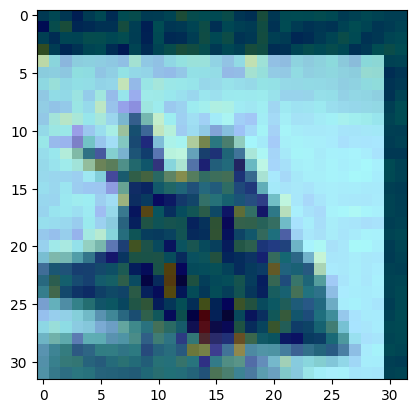

In [359]:
rescaled_grad = rescale_batch(grads)
rescaled_x = rescale_batch(mb_x)

overlayed = show_cam_on_image(rescaled_x, rescaled_grad,image_weight=0.7)
plt.imshow(overlayed.squeeze(0).permute(1,2,0).numpy())

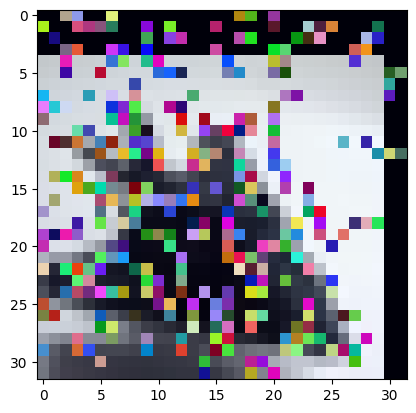

In [360]:
plt.imshow(rescale_batch(masked_input).squeeze(0).permute(1,2,0).numpy())